This notebook demonstrates the covariance matrix approach to contrast calculation with simple, single-reference subtraction.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 100

from pandeia_coronagraphy import scene, analysis, engine

from copy import deepcopy
import numpy as np

# Target and Reference Calculations

To compute the contrast from the correlated speckle, shot, and detector noise, we'll need to create multiple realizations of target and reference observations.

We begin by defining simple target and reference templates.

In [2]:
# The target is just a duplicate of the template
target = engine.load_calculation( engine.get_template('nircam_coronagraphy_template.json') )

# We adopt a brighter but spectrally-mismatched reference (compared to target 5.2 mag and a5v)
reference = engine.load_calculation( engine.get_template('nircam_coronagraphy_template.json') )
refstar = reference['scene'][0]
refstar['spectrum']['normalization']['norm_flux'] = 4.8
refstar['spectrum']['sed']['key'] = 'a3v'

We iterate over 10 realizations of target acquisition error (both target and reference) and the predicted WFE to build up the statistical sample from which we'll compute the contrast.

Here we assume that the WFE is unchanged between target and reference observations. A more complete approach would account for thermally- and dynamically-induced changes in the wavefront between pairs of observations.

(Note that this isn't the most efficient loop one could construct. If you want to quickly run this code, set `engine.options.wave_sampling = 3` and `engine.options.on_the_fly_PSFs = False`, or else rewrite to take better advantage of multiprocessing.)

In [3]:
engine.options.wave_sampling = 20 # 3
engine.options.on_the_fly_PSFs = True # False

n_observations = 10 # number of realizations

target_slopes = []
reference_slopes = []
for n in range(n_observations):
    # Add unique target acq error to the target
    current_target = deepcopy(target)
    scene.offset_scene(current_target['scene'], *scene.get_ta_error() )
    
    # Add unique target acq error to the reference
    current_reference = deepcopy(reference)
    scene.offset_scene(current_reference['scene'], *scene.get_ta_error() )
    
    # Adopt a new realization of the WFE.
    # Note that we're using the same WFE for target and reference here.
    engine.options.on_the_fly_webbpsf_opd = ('OPD_RevW_ote_for_NIRCam_predicted.fits', n)
    
    # Calculate target and reference
    targcalc, refcalc = engine.calculate_batch([current_target, current_reference])
    target_slopes.append(targcalc['2d']['detector'])
    reference_slopes.append(refcalc['2d']['detector'])

And, finally, we make an observation of an off-axis target for the normalization.

In [4]:
offaxis = engine.load_calculation( engine.get_template('nircam_coronagraphy_template.json') )
offaxis['calculation']['effects']['saturation'] = False # Disable saturation
scene.offset_scene(offaxis['scene'], 0.5, 0.5) #arsec

offaxis_slope = engine.perform_calculation(offaxis)['2d']['detector']

So now we have 10 target observations, 10 corresponding reference observations, and 1 off-axis observation.

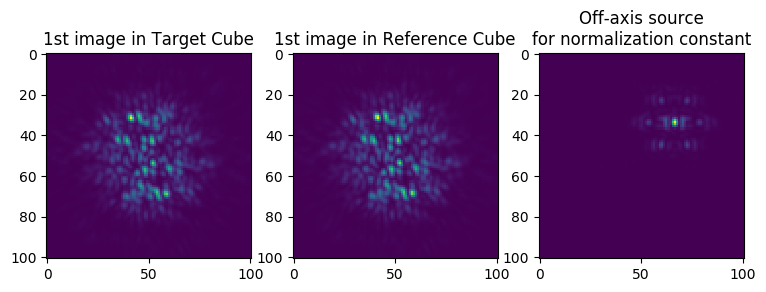

In [5]:
fig, axes = plt.subplots(1, 3, figsize = (9, 3))

axes[0].imshow(target_slopes[0])
axes[0].set_title('1st image in Target Cube')
axes[1].imshow(reference_slopes[0])
axes[1].set_title('1st image in Reference Cube')
axes[2].imshow(offaxis_slope)
axes[2].set_title('Off-axis source\nfor normalization constant')

# Contrast Calculation

### 1. Align each reference to its corresponding target and subtract

In [6]:
subtraction_stack = np.zeros((10,) + target_slopes[0].shape)
for i, (targ, ref) in enumerate(zip(target_slopes, reference_slopes)):
    aligned_ref = analysis.register_to_target(ref, targ) # Aligned, scaled, mean-centered reference
    subtraction_stack[i] = targ - np.nanmean(targ) - aligned_ref # Mean-center target and subtract reference
print(subtraction_stack.shape)

(10, 101, 101)


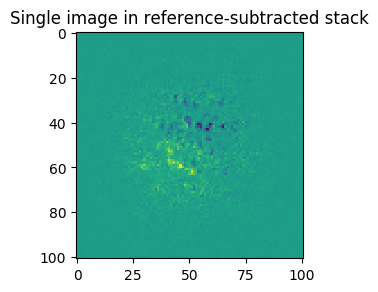

In [91]:
fig, ax = plt.subplots(1, 1, figsize = (3, 3))
ax.imshow(subtraction_stack[1])
ax.set_title('Single image in reference-subtracted stack')

### 2. Compute the covariance matrix from the stack of reference-subtracted targets

In [8]:
cov_matrix = analysis.covariance_matrix(subtraction_stack)
print(cov_matrix.shape)

(10201, 10201)


### 3. Compute the noise map

Here, we'll adopt a circular aperture and embed it in an array the size of our slope images. (In theory, this aperture could be of any shape, as long as it's embedded in an array of the right size.)

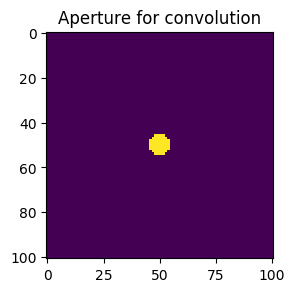

In [9]:
from skimage import draw
image_dim = subtraction_stack[0].shape
radius = 5
aperture_image = np.zeros(image_dim)
aperture_image[draw.circle((image_dim[0] - 1) // 2, (image_dim[1] - 1) // 2, radius)] = 1

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.imshow(aperture_image)
ax.set_title('Aperture for convolution')

From this aperture, we'll compute an "aperture matrix", which is really just the flattened aperture centered at each pixel in the image. It's essentially an intermediate step in a convolution, designed here to match the structure of the covariance matrix we've already computed.

And from the covariance and aperture matrices, we can create a map of the correlated noise within that aperture seen at each pixel.

In [10]:
aperture_matrix = analysis.aperture_matrix(aperture_image)
noise_map = analysis.noise_map(cov_matrix, aperture_matrix, image_dim)
print(noise_map.shape)

(101, 101)


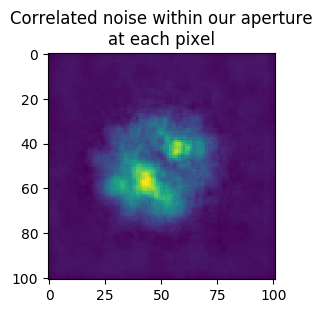

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.imshow(noise_map)
ax.set_title('Correlated noise within our aperture\nat each pixel')

### 4. Take the radial profile of the noise map (normalized by off-axis source in same aperture) to get the contrast curve

Convolve the off-axis source with the same aperture and take the maximum. This is the normalization constant.

('Normalization constant (e-/s): ', 14661055.637107268)


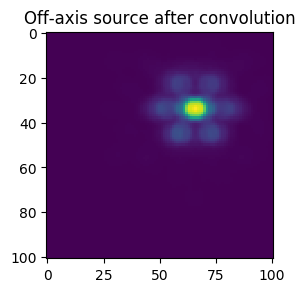

In [12]:
from scipy.ndimage import convolve

convolved_offaxis = convolve(offaxis_slope, aperture_image, mode='constant')
normalization = convolved_offaxis.max()

print('Normalization constant (e-/s): ', normalization)
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.imshow(convolved_offaxis)
ax.set_title('Off-axis source after convolution')

Take a radial profile of the noise map, normalize by the constant above, and scale the radial bins by the detector pixelscale.

(5e-06, 0.0001)

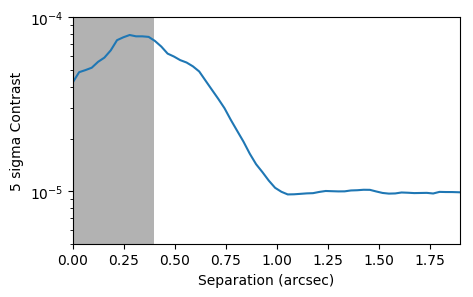

In [17]:
bins, profile = analysis.radial_profile(noise_map)

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.semilogy(bins * 0.031, 5 * profile / normalization)
ax.set_xlabel('Separation (arcsec)')
ax.set_ylabel('5 sigma Contrast')

#mask out any separations < IWA for the NIRCam M210R occulter
ax.fill_between([0, 0.4], 1e-7, 1e-3, color = 'k', alpha = 0.3, lw = 0)
ax.set_xlim(0,1.9)
ax.set_ylim(5e-6,1e-4)

# The Easy Way

Once you've settled on an aperture and have generated a set of images, you can pretty much jump through steps 2 - 4 above in a single call to `analysis.compute_contrast`.

In [14]:
bins, normalized_profile = analysis.compute_contrast(subtraction_stack, offaxis_slope, aperture_image)

(5e-06, 0.0001)

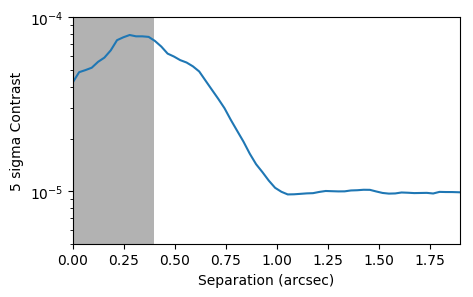

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.semilogy(bins * 0.031, 5 * normalized_profile)
ax.set_xlabel('Separation (arcsec)')
ax.set_ylabel('5 sigma Contrast')

#mask out any separations < IWA for the NIRCam M210R occulter
ax.fill_between([0, 0.4], 1e-7, 1e-3, color = 'k', alpha = 0.3, lw = 0)
ax.set_xlim(0,1.9)
ax.set_ylim(5e-6,1e-4)